j = 0


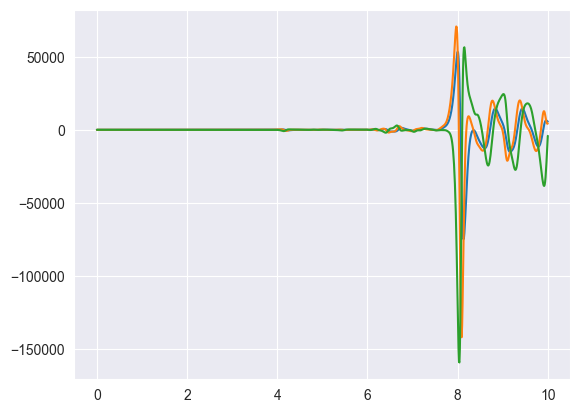

In [7]:
from numba import njit
from pylab import *
from scipy.integrate import solve_ivp

sigma = 15
beta = 8/3
rho = 28

T = 10
N = 1000
h = T/N # should be around 0.01

@njit
def f(t, x):
    y = empty(3, dtype=float64)
    y[0] = sigma * (x[1] - x[0])
    y[1] = rho*x[0] - x[1] - x[0]*x[2]
    y[2] = x[0]*x[1] - beta*x[2]
    return y

@njit
def fDf(x):
    y = empty(6, dtype=float64)
    y[0] = sigma * (x[1] - x[0])
    y[1] = rho*x[0] - x[1] - x[0]*x[2]
    y[2] = x[0]*x[1] - beta*x[2]
    y[3] = sigma * (x[4] - x[3])
    y[4] = (rho-x[2])*x[3] - x[4] - x[0]*x[5]
    y[5] = x[1]*x[3] + x[0]*x[4] - beta*x[5]
    return y

@njit
def rk_integrate(x):
    sol = empty((N+1, 6))
    sol[0] = x
    for i in range(N):
        k1 = h * fDf(x)
        k2 = h * fDf(x + 0.5*k1)
        k3 = h * fDf(x + 0.5*k2)
        k4 = h * fDf(x + k3)
        x += (k1 + 2.0*k2 + 2.0*k3 + k4)/6.0
        sol[i+1] = x
    return sol


x0 = (1,2,3)
sol0 = solve_ivp(f, [0,200], x0)

theta = 3*pi/4
deltaf = array((cos(theta), sin(theta), 0))
x = r_[sol0.y[:,-1], deltaf]

M = 1000
response = zeros((N+1, 3))

for j in range(M):
    response += rk_integrate(x)[:,3:]
    if j%1000 == 0:
        print (f"j = {j}")
        #print (f"j = {j}, response = {response/(j+1)}")
    x[3:] = deltaf

response /= M

figure()
tt = linspace(0, T, N+1)
plot(tt, response)

show()





j = 0
j = 1000
j = 2000
j = 3000
j = 4000
j = 5000
j = 6000
j = 7000
j = 8000
j = 9000


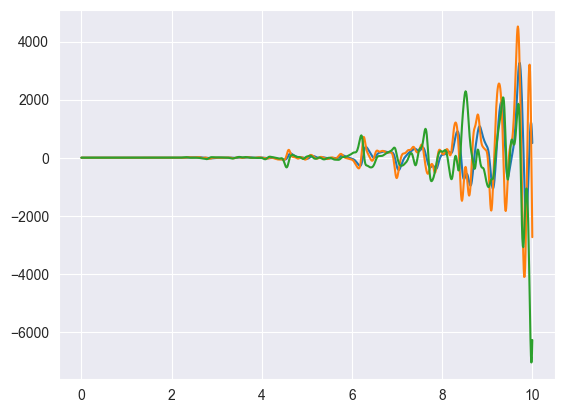

In [8]:
M = 10000
response = zeros((N+1, 3))

for j in range(M):
    response += rk_integrate(x)[:,3:]
    if j%1000 == 0:
        print (f"j = {j}")
        #print (f"j = {j}, response = {response/(j+1)}")
    x[3:] = deltaf

response /= M

figure()
tt = linspace(0, T, N+1)
plot(tt, response)

show()

j = 0
j = 1000
j = 2000
j = 3000
j = 4000
j = 5000
j = 6000
j = 7000
j = 8000
j = 9000
j = 10000
j = 11000
j = 12000
j = 13000
j = 14000
j = 15000
j = 16000
j = 17000
j = 18000
j = 19000
j = 20000
j = 21000
j = 22000
j = 23000
j = 24000
j = 25000
j = 26000
j = 27000
j = 28000
j = 29000
j = 30000
j = 31000
j = 32000
j = 33000
j = 34000
j = 35000
j = 36000
j = 37000
j = 38000
j = 39000
j = 40000
j = 41000
j = 42000
j = 43000
j = 44000
j = 45000
j = 46000
j = 47000
j = 48000
j = 49000
j = 50000
j = 51000
j = 52000
j = 53000
j = 54000
j = 55000
j = 56000
j = 57000
j = 58000
j = 59000
j = 60000
j = 61000
j = 62000
j = 63000
j = 64000
j = 65000
j = 66000
j = 67000
j = 68000
j = 69000
j = 70000
j = 71000
j = 72000
j = 73000
j = 74000
j = 75000
j = 76000
j = 77000
j = 78000
j = 79000
j = 80000
j = 81000
j = 82000
j = 83000
j = 84000
j = 85000
j = 86000
j = 87000
j = 88000
j = 89000
j = 90000
j = 91000
j = 92000
j = 93000
j = 94000
j = 95000
j = 96000
j = 97000
j = 98000
j = 99000


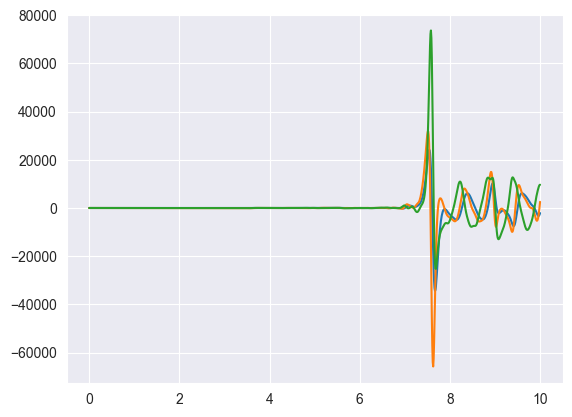

In [9]:
M = 100000
response = zeros((N+1, 3))

for j in range(M):
    response += rk_integrate(x)[:,3:]
    if j%1000 == 0:
        print (f"j = {j}")
        #print (f"j = {j}, response = {response/(j+1)}")
    x[3:] = deltaf

response /= M

figure()
tt = linspace(0, T, N+1)
plot(tt, response)

show()

chunk 1/100 done
chunk 2/100 done
chunk 3/100 done
chunk 4/100 done
chunk 5/100 done
chunk 6/100 done
chunk 7/100 done
chunk 8/100 done
chunk 9/100 done
chunk 10/100 done
chunk 11/100 done
chunk 12/100 done
chunk 13/100 done
chunk 14/100 done
chunk 15/100 done
chunk 16/100 done
chunk 17/100 done
chunk 18/100 done
chunk 19/100 done
chunk 20/100 done
chunk 21/100 done
chunk 22/100 done
chunk 23/100 done
chunk 24/100 done
chunk 25/100 done
chunk 26/100 done
chunk 27/100 done
chunk 28/100 done
chunk 29/100 done
chunk 30/100 done
chunk 31/100 done
chunk 32/100 done
chunk 33/100 done
chunk 34/100 done
chunk 35/100 done
chunk 36/100 done
chunk 37/100 done
chunk 38/100 done
chunk 39/100 done
chunk 40/100 done
chunk 41/100 done
chunk 42/100 done
chunk 43/100 done
chunk 44/100 done
chunk 45/100 done
chunk 46/100 done
chunk 47/100 done
chunk 48/100 done
chunk 49/100 done
chunk 50/100 done
chunk 51/100 done
chunk 52/100 done
chunk 53/100 done
chunk 54/100 done
chunk 55/100 done
chunk 56/100 done
c

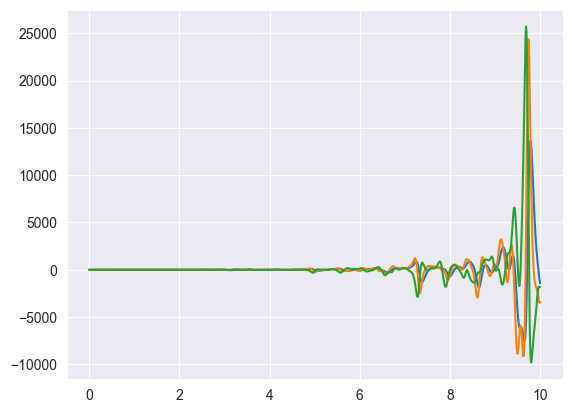

In [12]:
M = 100000      # 1e6
chunk = 1000    # 每段1万
num_chunks = M // chunk

response = zeros((N+1, 3))

for i in range(num_chunks):
    tmp = zeros((N+1, 3))
    for j in range(chunk):
        tmp += rk_integrate(x)[:,3:]
        x[3:] = deltaf
    tmp /= chunk
    response += tmp
    print(f"chunk {i+1}/{num_chunks} done")

response /= num_chunks

figure()
tt = linspace(0, T, N+1)
plot(tt, response)
show()

Total M = 100000

=== Window 1/10 ===
window 1, j = 0/10000
window 1, j = 1000/10000
window 1, j = 2000/10000
window 1, j = 3000/10000
window 1, j = 4000/10000
window 1, j = 5000/10000
window 1, j = 6000/10000
window 1, j = 7000/10000
window 1, j = 8000/10000
window 1, j = 9000/10000

=== Window 2/10 ===
window 2, j = 0/10000
window 2, j = 1000/10000
window 2, j = 2000/10000
window 2, j = 3000/10000
window 2, j = 4000/10000
window 2, j = 5000/10000
window 2, j = 6000/10000
window 2, j = 7000/10000
window 2, j = 8000/10000
window 2, j = 9000/10000

=== Window 3/10 ===
window 3, j = 0/10000
window 3, j = 1000/10000
window 3, j = 2000/10000
window 3, j = 3000/10000
window 3, j = 4000/10000
window 3, j = 5000/10000
window 3, j = 6000/10000
window 3, j = 7000/10000
window 3, j = 8000/10000
window 3, j = 9000/10000

=== Window 4/10 ===
window 4, j = 0/10000
window 4, j = 1000/10000
window 4, j = 2000/10000
window 4, j = 3000/10000
window 4, j = 4000/10000
window 4, j = 5000/10000
window 4, j

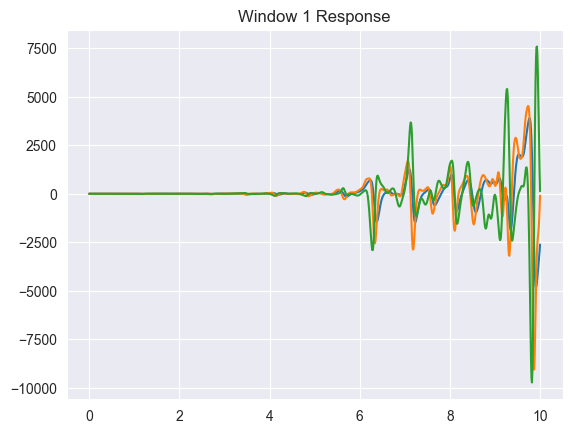

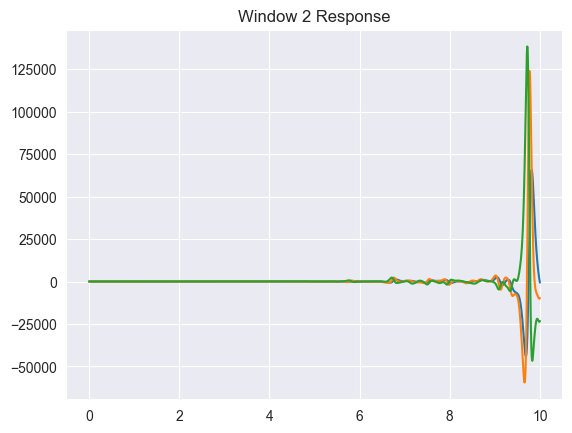

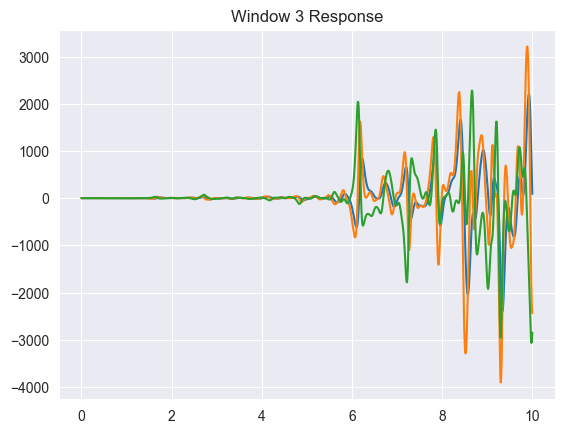

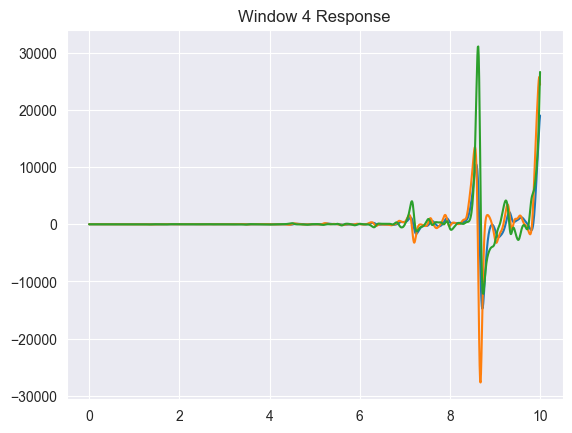

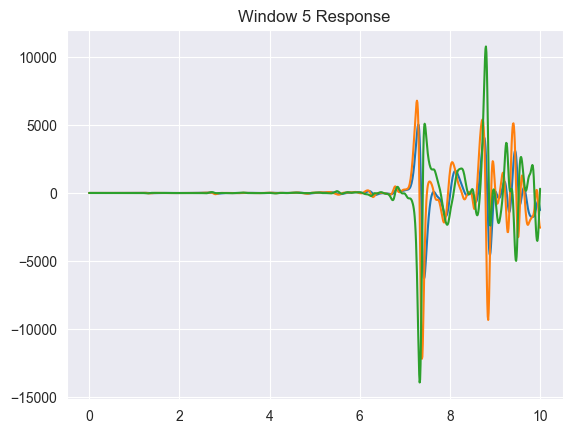

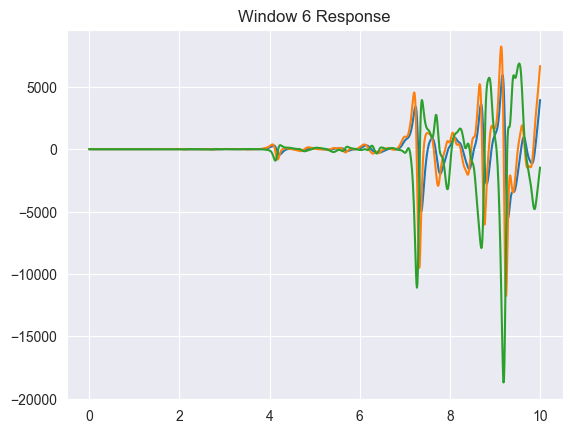

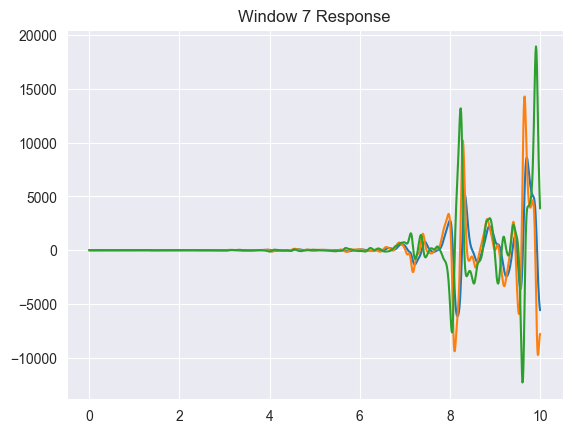

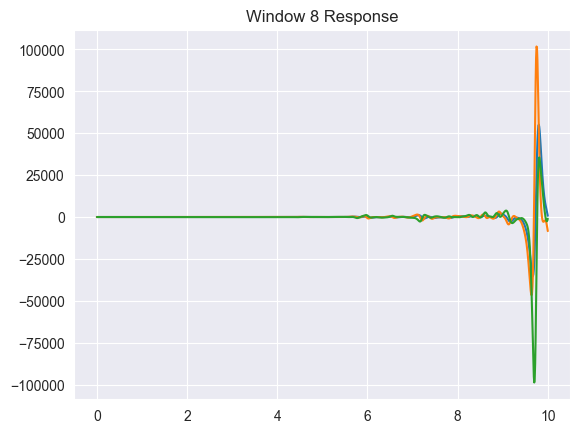

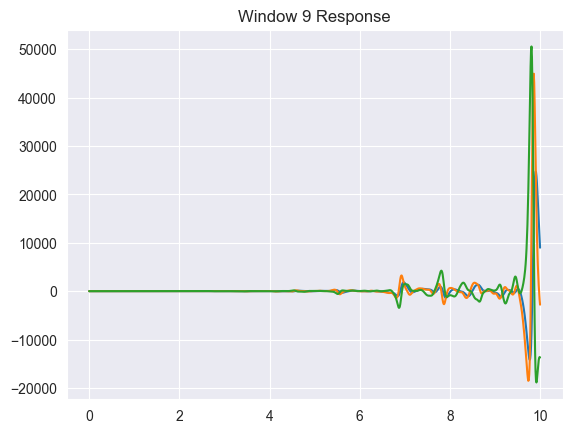

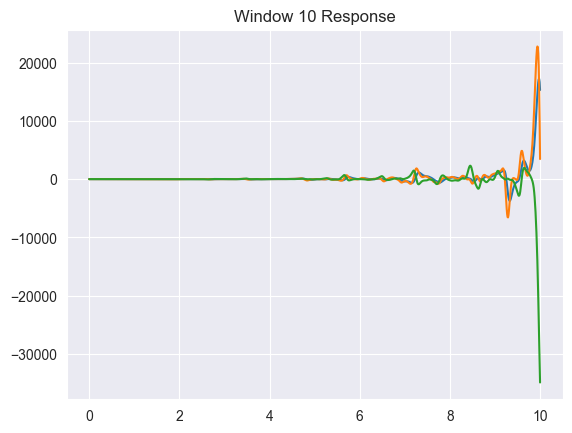

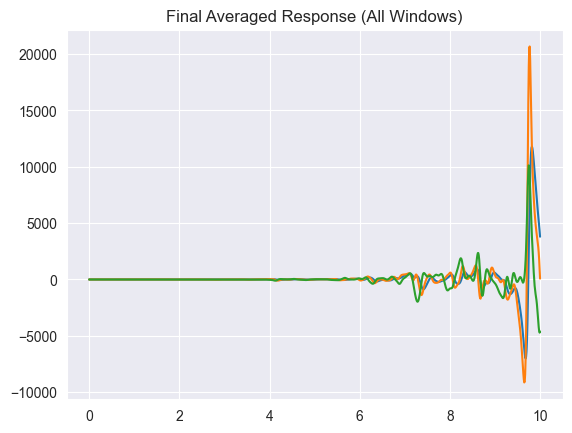

In [15]:
# 参数
num_windows = 10
chunk = 10000
M = num_windows * chunk
print(f"Total M = {M}")

# 初始化
response = zeros((N+1, 3))
all_responses = []   # 🌟 存每个 window 自己的曲线

# 多窗口循环
for window in range(num_windows):
    print(f"\n=== Window {window+1}/{num_windows} ===")

    # attractor 起点
    x0_random = np.random.uniform(-10, 10, size=3)
    sol0 = solve_ivp(f, [0, 200], x0_random)
    x = r_[sol0.y[:, -1], deltaf]

    # 窗口内部 tree sum
    tmp = zeros((N+1, 3))
    for j in range(chunk):
        tmp += rk_integrate(x)[:, 3:]
        x[3:] = deltaf
        if j % 1000 == 0:
            print(f"window {window+1}, j = {j}/{chunk}")

    tmp /= chunk
    response += tmp

    # 🌟 保存当前 window 的结果
    all_responses.append(tmp.copy())

# 最终平均
response /= num_windows

# 🌟 画所有 window 单独图
for i, tmp in enumerate(all_responses):
    figure()
    tt = linspace(0, T, N+1)
    plot(tt, tmp)
    title(f"Window {i+1} Response")
    show()

# 🌟 画最终平均图
figure()
plot(tt, response)
title("Final Averaged Response (All Windows)")
show()
